### Integrantes


**Nombre Completo:** Edwar Alejandro Ramírez Londoño

**Cédula:** 1060588666

**Correo Institucional:** edwar.ramirez@udea.edu.co


**Nombre Completo:** Sebastian Giraldo Zuluaga

**Cédula:** 1041204644

**Correo Institucional:** sebastian.giraldoz@udea.edu.co


### Descripción
El data set con el cual se trabajó, fue descargado de la página de The National Renewable Energy Laboratory (NREL), el cual se especializa en la ingestigación y desarrollo de energía renovable, eficiencia energética, integración de sistemas de energía y transporte sostenible.
Son datos obtenidos a través de reanalisis que provee el estado de las variables meteorológicas del pasasdo. Estos datos son construidos con mediciones u obsevaciones realizadas y pronóstico de las variables en el pasado basado en modelos de predicción modernos.

Las variables usadas para hacer la predicción de la velocidad del viento son descargadas con base en las coordenadas (11.77, -72.44). Este lugar está ubicado en la zona norte de colombia donde se tiene diferentes proyectos de generación eólica. Se toamron los datos desde el 01/01/2019 hora 1, hasta l 31/12/2021 hora 24, para un total de 26280 registros. A continuación se listan las variables tomadas:

- Temperatura (°C)
- Punto de rocio (°C)
- Ozono (ud)
- Humedad realtiva (%)
- Presión (mbar)
- Precipitaciones (cm)
- Dirección del viento (grados)
- Velocidad del viento (m/seg)


Origen de los datos: https://nsrdb.nrel.gov/data-viewer

### Librerías

In [1]:
import pandas as pd
import numpy as np
#from lib import mlutils
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt


from sklearn.impute import MissingIndicator # Es una función que permite identificar los datos faltantes
from sklearn.impute import KNNImputer # Se utiliza la función KNNIMputer para aplicar la imputación KNN
from sklearn.impute import SimpleImputer # Método de imputación 
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor # Algoritmo LOF
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

from scipy.stats import spearmanr
from scipy.special import entr # Entropía de Shannon

#Creación de modelo
import statsmodels.api as sm
#Factor de Inflación de la Varianza VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Evaluación del modelo
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

from sklearn.linear_model import LinearRegression # Algoritmo para crear el modelo de regresión lineal múltiple

#Creación de modelo
from sklearn.svm import SVR

from sklearn.model_selection import GridSearchCV

#Creación de modelo
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

#creación de modelos
from sklearn.ensemble import RandomForestRegressor




### Preparación de los datos

In [2]:
#Lectura de los datos
Dir=Path(os.getcwd())
Dir_parent = Dir.parent
lYears=['2019','2020','2021']
Wind_df=pd.DataFrame()
for year in lYears:
    pathfile=str(Dir) + f'\\Wind_Prediction_Data\\{year}_Wind_Data.csv'
    print(pathfile)
    df = pd.read_csv(pathfile, header=0, sep=',')
    Wind_df=pd.concat([Wind_df,df],axis=0)

Wind_df.head()
Wind_df.reset_index(inplace=True,drop=True)

d:\AprendizajeDesarrollo\EspecializacionAnalitica\Monografía\Entregable2\Wind_Prediction_Data\2019_Wind_Data.csv
d:\AprendizajeDesarrollo\EspecializacionAnalitica\Monografía\Entregable2\Wind_Prediction_Data\2020_Wind_Data.csv
d:\AprendizajeDesarrollo\EspecializacionAnalitica\Monografía\Entregable2\Wind_Prediction_Data\2021_Wind_Data.csv


In [3]:
#Información inicial del dataset
Wind_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                26280 non-null  int64  
 1   Month               26280 non-null  int64  
 2   Day                 26280 non-null  int64  
 3   Hour                26280 non-null  int64  
 4   Minute              26280 non-null  int64  
 5   DHI                 26280 non-null  int64  
 6   Temperature         26280 non-null  float64
 7   Clearsky DHI        26280 non-null  int64  
 8   Clearsky DNI        26280 non-null  int64  
 9   Clearsky GHI        26280 non-null  int64  
 10  Cloud Type          26280 non-null  int64  
 11  Dew Point           26280 non-null  float64
 12  DNI                 26280 non-null  int64  
 13  Fill Flag           26280 non-null  int64  
 14  GHI                 26280 non-null  int64  
 15  Ozone               26280 non-null  float64
 16  Rela

Se toman 1001 registros para hacer las validaciones iniciales de lo mejores modelos y hacer grid search.

In [4]:
# Calcular la cantidad de valores NaN en cada columna
nans_por_col = Wind_df.isna().sum()

# Calcular el porcentaje de valores NaN en cada columna
porcentaje_nans_por_col = (nans_por_col / len(Wind_df)) * 100

# Crear un DataFrame que muestre los resultados
resultados = pd.concat([nans_por_col, porcentaje_nans_por_col], axis=1, keys=['Cantidad de NaN', 'Porcentaje de NaN'])

resultados = resultados.sort_values(by='Cantidad de NaN', ascending=True)
resultados=resultados.reset_index()
print(resultados)

                 index  Cantidad de NaN  Porcentaje de NaN
0                 Year                0                0.0
1   Precipitable Water                0                0.0
2             Pressure                0                0.0
3       Surface Albedo                0                0.0
4   Solar Zenith Angle                0                0.0
5    Relative Humidity                0                0.0
6                Ozone                0                0.0
7                  GHI                0                0.0
8            Fill Flag                0                0.0
9                  DNI                0                0.0
10      Wind Direction                0                0.0
11           Dew Point                0                0.0
12        Clearsky GHI                0                0.0
13        Clearsky DNI                0                0.0
14        Clearsky DHI                0                0.0
15         Temperature                0                0

In [5]:
Indicador = MissingIndicator(missing_values = np.nan)
Indicador.fit(Wind_df) 
Datos_Indicador = Indicador.transform(Wind_df) # Realizamos una transformación Booleana de los datos para identificar los datos faltantes (True)
                                             # y los datos no faltantes (False)
print("Características donde hay datos faltantes: ", Indicador.features_)

Características donde hay datos faltantes:  []


Se observa que no se tiene datos faltantes en el dataset

In [6]:
# Verificación de datos duplicados
dd=Wind_df.loc[Wind_df.duplicated()]
dd
print(dd.shape)

(0, 23)


No se tienen datos duplicados en el dataset

**Normalización de datos**


In [7]:
#Se eliminan las columns que no se requieren para el análisis
# No se toaman datos de fechas debido a que no se va a realizar modelo que tengan en cuenta series de tiempo por el momento.
df_Wind=Wind_df.drop(columns=['Year','Month','Day','Hour','Minute','DNI','DHI','Fill Flag','GHI','Clearsky DHI','Clearsky DNI','Clearsky GHI','Cloud Type','Surface Albedo','Solar Zenith Angle'], axis=1)
df_Wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Temperature         26280 non-null  float64
 1   Dew Point           26280 non-null  float64
 2   Ozone               26280 non-null  float64
 3   Relative Humidity   26280 non-null  float64
 4   Pressure            26280 non-null  int64  
 5   Precipitable Water  26280 non-null  float64
 6   Wind Direction      26280 non-null  int64  
 7   Wind Speed          26280 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 1.6 MB


In [8]:
MinMax = MinMaxScaler(copy=True, feature_range=(0, 1)) 
nombres = df_Wind.columns
Datos_Min_Max = MinMax.fit_transform(df_Wind)
Datos_Min_Max = pd.DataFrame(Datos_Min_Max, columns = nombres)

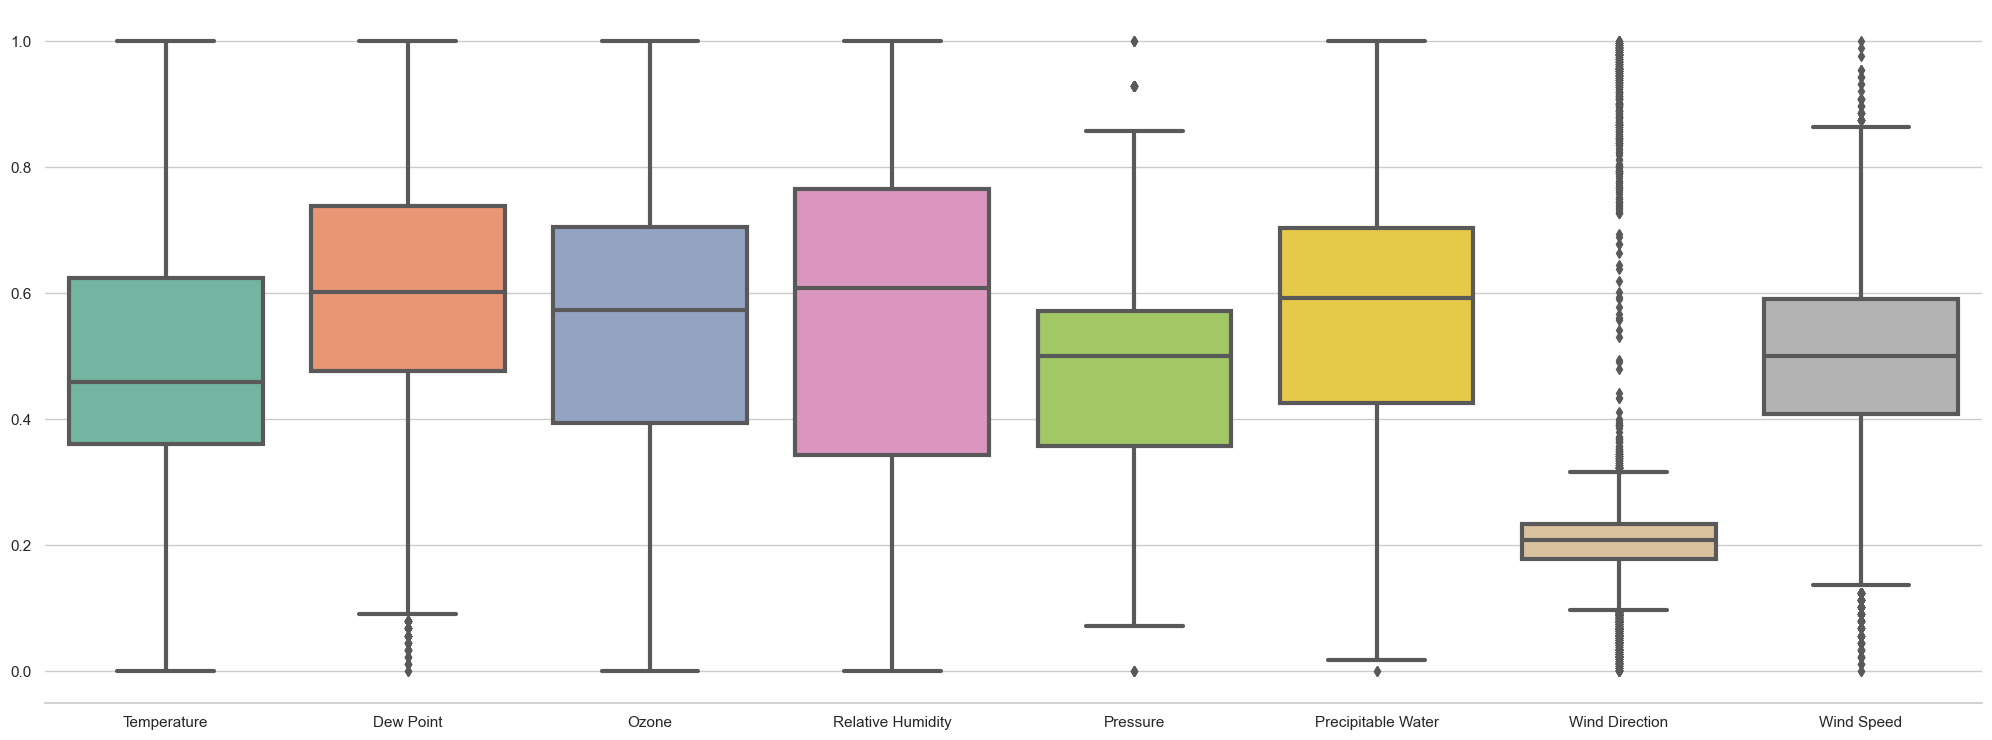

In [9]:
#Se realiza un diagrama de cajas a los datos normalizados
sns.set(rc={'figure.figsize':(25,9)}) 
sns.set(style="whitegrid") 
sns.boxplot(data = Datos_Min_Max, linewidth = 3, palette="Set2", fliersize = 5)
sns.despine(left=True)

No se obserca un cantidad considerable de datos atípicos, sin embargo se va a reliazar análisis de datos atípicos para validar si se detectan algunos.

**Detección de datos atípicos**

In [10]:
LOF = LocalOutlierFactor(n_neighbors = 7, algorithm = 'auto', contamination = 'auto', metric = 'euclidean') 

Filtrado = LOF.fit_predict(Datos_Min_Max) 
NOF = LOF.negative_outlier_factor_ 

radio_outiler = (NOF.max() - NOF)/(NOF.max() - NOF.min())
ground_truth = np.ones(len(Datos_Min_Max), dtype = int) 
n_errors = (Filtrado != ground_truth).sum() # número de datos atípicos

In [11]:
print("Número de muestras o filas con datos atípicos: ", n_errors)

Número de muestras o filas con datos atípicos:  26


Se presenta un total de 26 datos atpicos que son removidos del dataset.

In [12]:
pos = np.where(Filtrado == ground_truth) # Se identifican en que muestras o filas de nuestra base de datos hay presencia de datos atípicos
pos = np.asarray(pos)
pos = np.hstack(pos)
datos_sin_outilers_LOF = Datos_Min_Max.loc[pos, :]
Datos_Ori_sin_out=df_Wind.loc[pos, :]
print(Datos_Min_Max.shape) # Tamaño de los datos originales
print(datos_sin_outilers_LOF.shape) # Tamañno de los datos sin outliers 


(26280, 8)
(26254, 8)


In [14]:
sColumns=DatosFiltrados.columns
DatosFiltrados=datos_sin_outilers_LOF.copy()
Features = DatosFiltrados[sColumns]

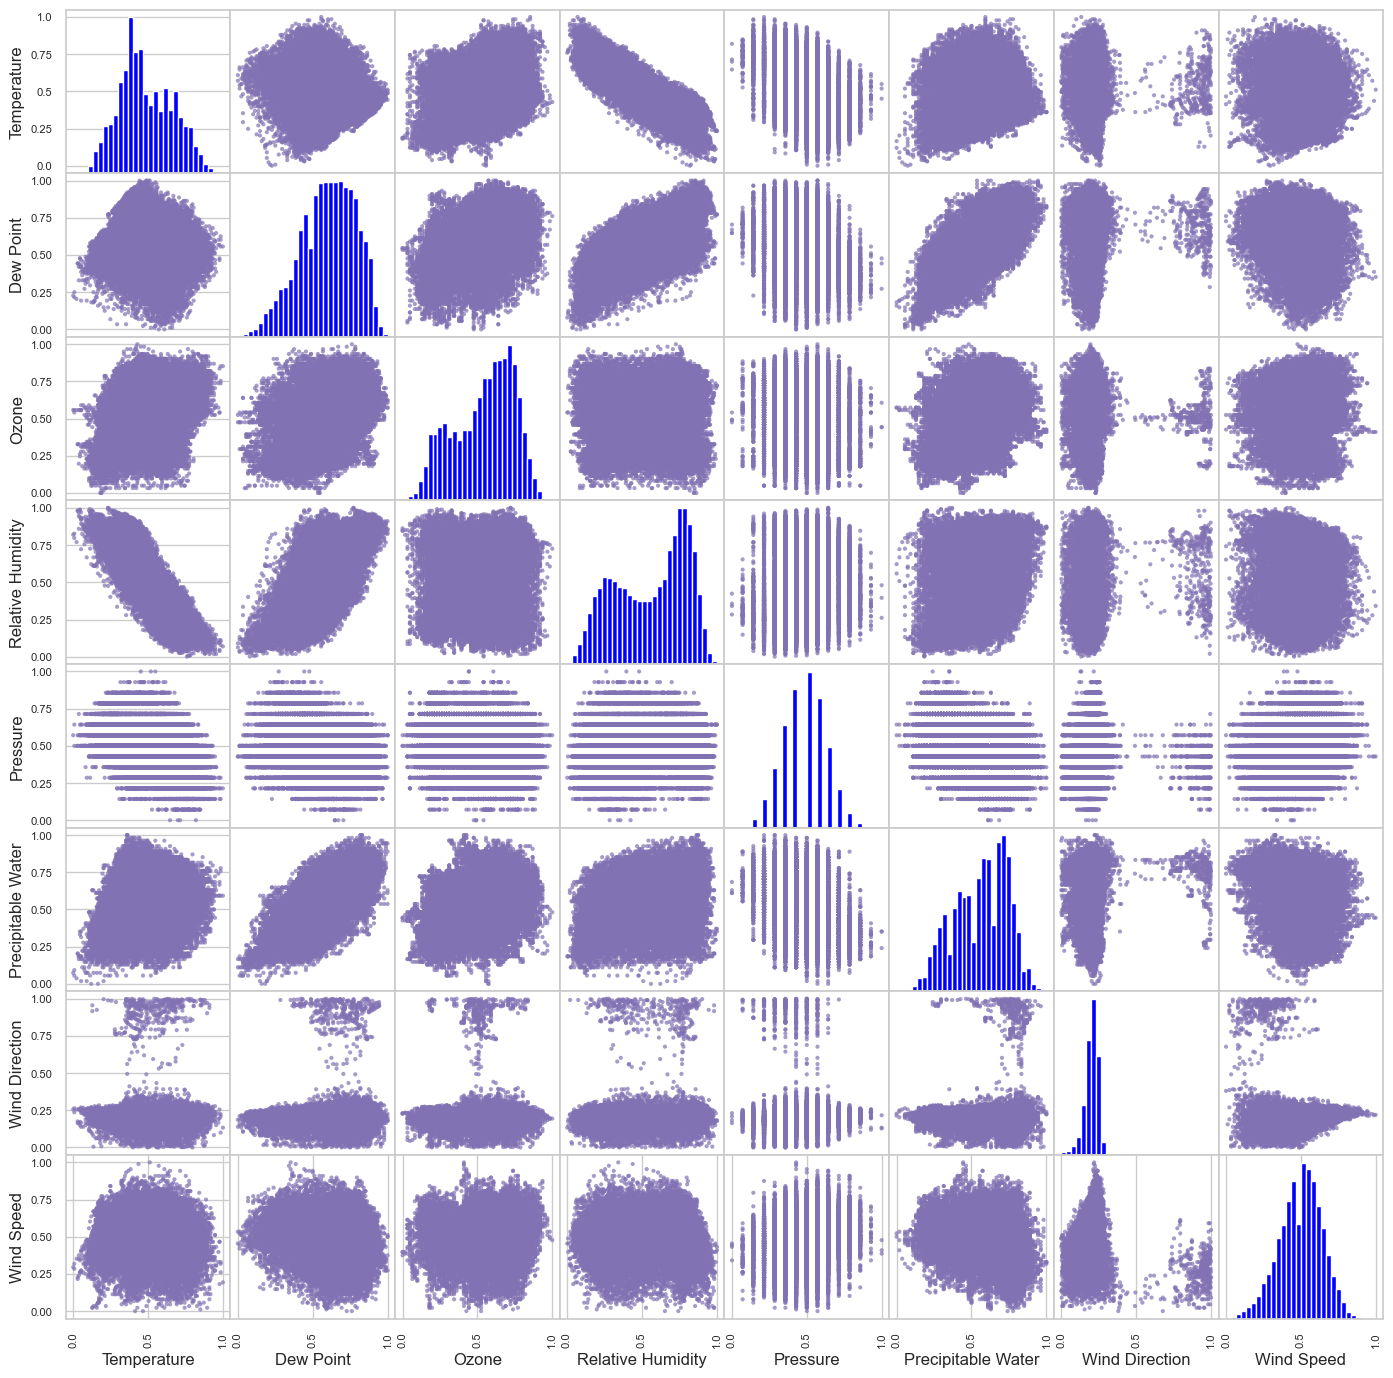

In [15]:
#Se realiza una gráfica para observar la correlación de los datos
pd.plotting.scatter_matrix(Features, alpha=0.7, figsize=(17,17), range_padding = 0.1, diagonal='hist',
                           color = 'm', hist_kwds = {'bins':30, 'color':'blue'}) # Grafica de dispersión e histograma
plt.show()

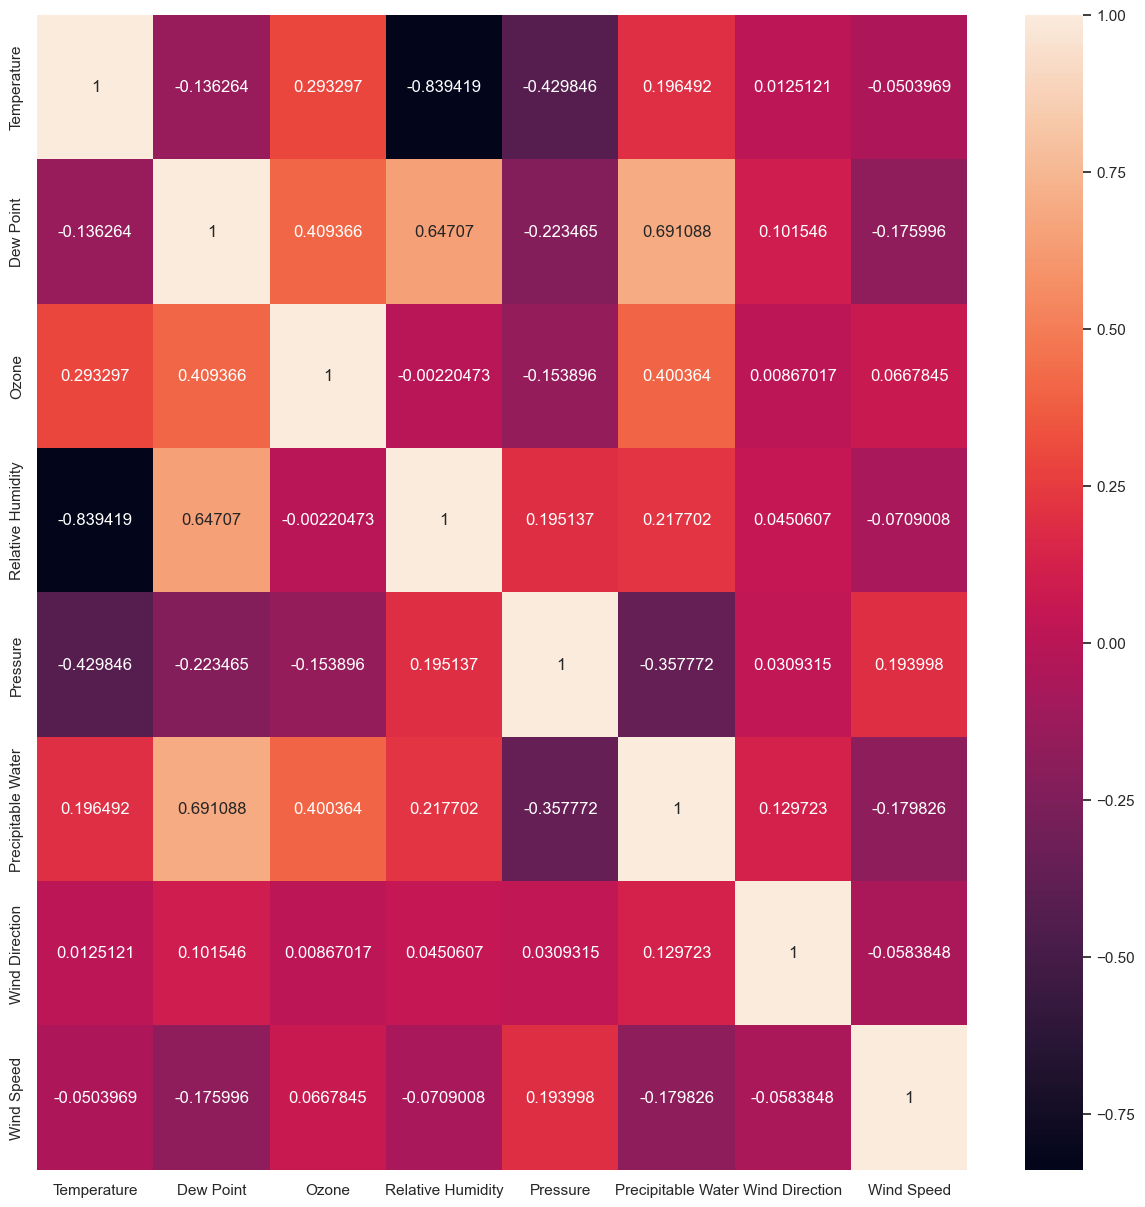

In [16]:
Matriz_Correlacion = Features.corr()
Caracteristicas = Features.columns
plt.figure(figsize=(15,15))
ax = sns.heatmap(Matriz_Correlacion, annot=True, fmt='g', xticklabels = Caracteristicas, yticklabels = Caracteristicas)
plt.show()

**Correlación de sperman**
Se utiliza esta herramienta para validar como se correlacionan las variables y poder determinar si alguna se puede elimininar.

In [17]:
#Cálculo de la correlación de spearman
spearman = []
valor_ps = []
Data_Wind = Features.values
Data_Wind = np.asarray(Data_Wind)

for _,n in enumerate(np.arange(0,Data_Wind.shape[1])):
  for _,m in enumerate(np.arange(0,Data_Wind.shape[1])):  
      s_valor, p_valor = spearmanr(Data_Wind[:,n], Data_Wind[:,m])
      spearman.append(s_valor)
      valor_ps.append(p_valor)

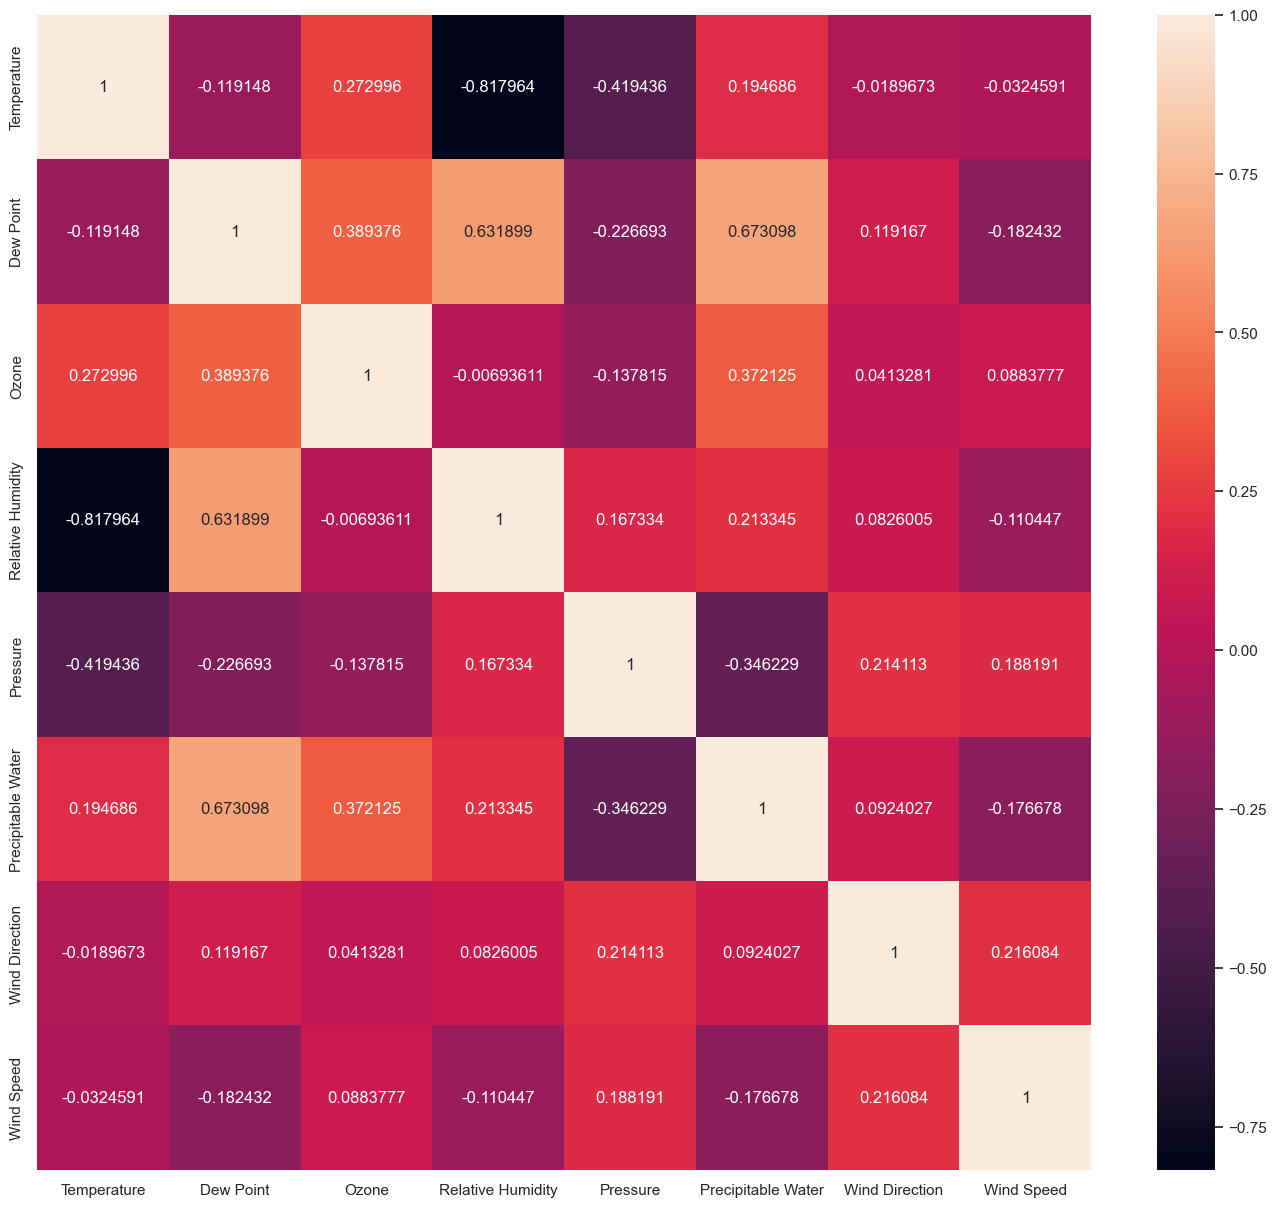

In [18]:
spearman = np.asarray(spearman)
valor_ps = np.asarray(valor_ps)

spearman_r = spearman.reshape(Data_Wind.shape[1],Data_Wind.shape[1])
p_value_s = valor_ps.reshape(Data_Wind.shape[1],Data_Wind.shape[1])

plt.figure(figsize=(17,15))
ax = sns.heatmap(spearman_r, annot=True, fmt='g', xticklabels = Caracteristicas, yticklabels = Caracteristicas)
plt.show()

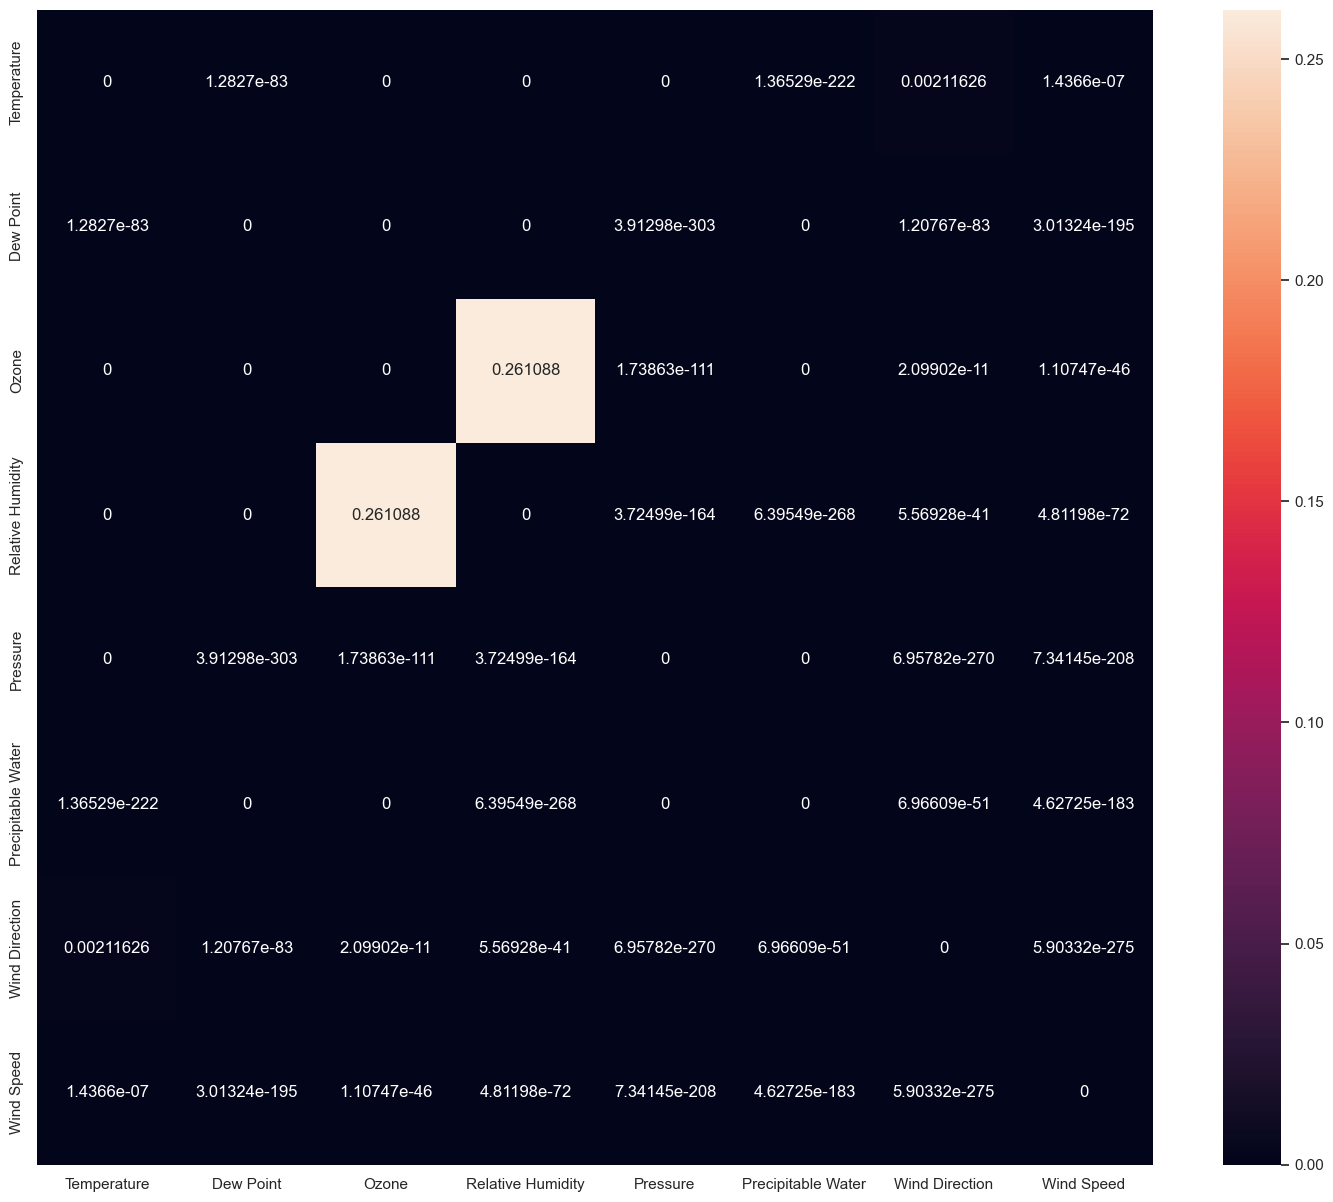

In [19]:
plt.figure(figsize=(18,15))
ax = sns.heatmap(p_value_s, annot=True, fmt='g', xticklabels = Caracteristicas, yticklabels = Caracteristicas)
plt.show()

Como p-value < 0.05 entre la humedad relativa-temperatura y la humedad relativa-punto de rocio, indicando que la primera tiene una relación lineal inversa y la segunda lineal. Esto indica que la variable humedad relativa es suceptible de eliminar.

## Creación del modelo

In [21]:
#Se establece las variables de entrada 'X' y la variable de salida 'y'
X = DatosFiltrados.drop(columns=['Wind Speed',], axis=1)
y = DatosFiltrados['Wind Speed']

In [22]:
# División de los datos en train y test
#En este caso, el 80% de los datos se utilizarán para entrenar el modelo. 
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values, 
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [23]:
modelRL       = LinearRegression()
modelRL.fit(X_train,y_train)


In [58]:
#Metrics for train
df_Metrics_mean=pd.DataFrame(columns=['r2','mae','rmse','models','type'])
df_Metrics_std=pd.DataFrame(columns=['r2','mae','rmse','models','type'])

CV=10
scoresr2 = cross_val_score(modelRL, X_train, y_train, cv=CV, scoring='r2')
scoresmse = cross_val_score(modelRL, X_train, y_train, cv=CV, scoring='neg_mean_absolute_error')
scoresrmse = cross_val_score(modelRL, X_train, y_train, cv=CV, scoring='neg_root_mean_squared_error')

df_Metrics_mean.loc[0]=[scoresr2.mean(),-1*scoresmse.mean(),-1*scoresrmse.mean(),'Regresion','train']
df_Metrics_std.loc[0]=[scoresr2.std(),scoresmse.std(),scoresrmse.std(),'Regresion','train']

#Metrics for test

scoresr2 = cross_val_score(modelRL, X_test, y_test, cv=CV, scoring='r2')
scoresmse = cross_val_score(modelRL, X_test, y_test, cv=CV, scoring='neg_mean_absolute_error')
scoresrmse = cross_val_score(modelRL, X_test, y_test, cv=CV, scoring='neg_root_mean_squared_error')

df_Metrics_mean.loc[1]=[scoresr2.mean(),-1*scoresmse.mean(),-1*scoresrmse.mean(),'Regresion','test']
df_Metrics_std.loc[1]=[scoresr2.std(),scoresmse.std(),scoresrmse.std(),'Regresion','test']


In [61]:
print(df_Metrics_mean)
print(df_Metrics_std)

         r2       mae      rmse     models   type
0  0.118359  0.104527  0.132382  Regresion  train
1  0.114834  0.105237  0.133444  Regresion   test
        r2       mae      rmse     models   type
0  0.01248  0.001419  0.001414  Regresion  train
1  0.01901  0.004180  0.005327  Regresion   test


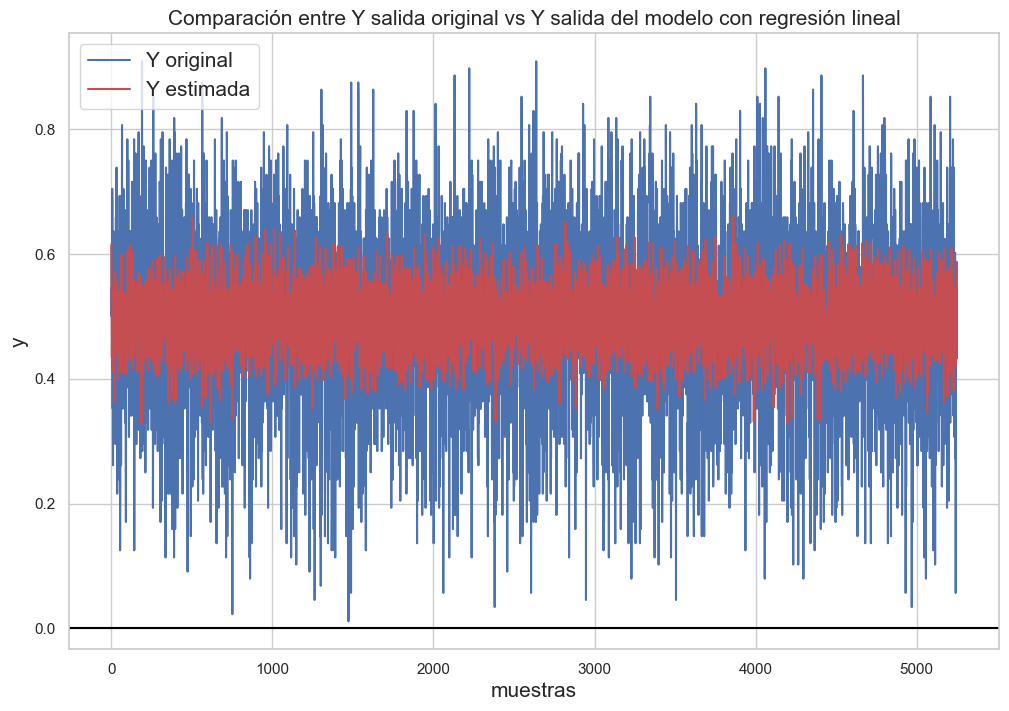

In [101]:
Y_predi = modelRL.predict(X_test) # Estima los valores de salida del modelo de regresión

fig = plt.figure(figsize=(12,8))
line_1 = plt.plot(np.arange(len(y_test)), y_test, 
                  color = 'b', label='Y original') 
line_2 = plt.plot(np.arange(len(y_test)), Y_predi, 
                  color = 'r', label='Y estimada') 
plt.axhline(0, color="black") # Elegir color de la linea horizontal de referencia
plt.legend(fontsize=15)
plt.title('Comparación entre Y salida original vs Y salida del modelo con regresión lineal',fontsize=15) # Titulo de la gráfica
plt.xlabel('muestras',fontsize=15) # Etiqueta del eje x
plt.ylabel('y',fontsize=15) # Etiqueta del eje y
plt.show() # Mostrar gráfica

### Creación del modelo Arboles de desición

##### Hipermarámetros del arbol de decisión

In [ ]:
# Se asigna a 'X_Completo' y 'y_Completo' los datos entrada y salida respectivamente para hcer el grid search con todos los datos
X_Completo = X
y_Completo = y

#Se entena el modelo con múltiples hiperparámetros buscando el mejor

#Se crea una instancia de una DecisionTreeRegressor 
dTreeR = DecisionTreeRegressor()

#Se establecen los hiperparámetros
parameters = {'max_depth': [2, 4, 6, 8, 10],
              'min_samples_split': [15, 30, 45, 60],
              'min_samples_leaf' : [15, 30, 45, 60],
              'max_features' : ['auto', 'sqrt', 'log2']
             }

# Se define un GridSearchCV con una validacion cruzada de 10 pliegues y con todos los 
#hierparametros establecidos anteriormente
grid = GridSearchCV(dTreeR, param_grid=parameters, cv=10, verbose=3)

#Se entrena el GridSearchCV anterior (2 min. aprox.) con los datos completos
grid_result = grid.fit(X_Completo,y_Completo) 

grid_result

In [64]:
# Se identifican los mejores hiperparámetros
best_params = grid_result.best_params_
print('Best Parameters : ',best_params)

Best Parameters :  {'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 60, 'min_samples_split': 30}


In [65]:
# Se crea un modelo árbol de decisión con los mejores hiperparámetros 
dTreeR = DecisionTreeRegressor( max_depth = 8
                               , min_samples_split = 30
                               , min_samples_leaf = 60
                               , max_features = 'auto'
                               , random_state = 1234)


#Se entrena el modelo con los datos de entrenamiento y prueba iniciales
dTreeR.fit(X_train, y_train)

c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


DecisionTreeRegressor(max_depth=8, max_features='auto', min_samples_leaf=60,
                      min_samples_split=30, random_state=1234)

In [ ]:
CV=10
scoresr2 = cross_val_score(dTreeR, X_train, y_train, cv=CV, scoring='r2')
scoresmse = cross_val_score(dTreeR, X_train, y_train, cv=CV, scoring='neg_mean_absolute_error')
scoresrmse = cross_val_score(dTreeR, X_train, y_train, cv=CV, scoring='neg_root_mean_squared_error')

df_Metrics_mean.loc[2]=[scoresr2.mean(),-1*scoresmse.mean(),-1*scoresrmse.mean(),'DT','train']
df_Metrics_std.loc[2]=[scoresr2.std(),scoresmse.std(),scoresrmse.std(),'DT','train']

#Metrics for test

scoresr2 = cross_val_score(dTreeR, X_test, y_test, cv=CV, scoring='r2')
scoresmse = cross_val_score(dTreeR, X_test, y_test, cv=CV, scoring='neg_mean_absolute_error')
scoresrmse = cross_val_score(dTreeR, X_test, y_test, cv=CV, scoring='neg_root_mean_squared_error')

df_Metrics_mean.loc[3]=[scoresr2.mean(),-1*scoresmse.mean(),-1*scoresrmse.mean(),'DT','test']
df_Metrics_std.loc[3]=[scoresr2.std(),scoresmse.std(),scoresrmse.std(),'DT','test']

In [69]:
df_Metrics_mean

,r2,mae,rmse,models,type
0,0.118359,0.104527,0.132382,Regresion,train
1,0.114834,0.105237,0.133444,Regresion,test
2,0.330897,0.089780,0.115326,DT,train
3,0.291512,0.092763,0.119340,DT,test


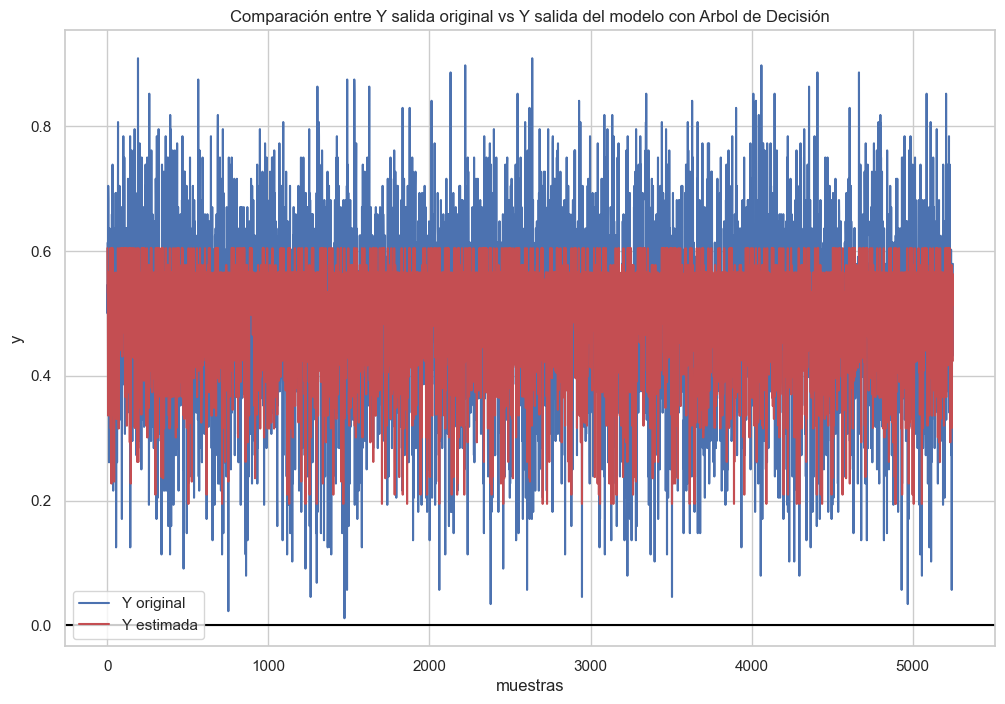

In [93]:
Y_prediDT = dTreeR.predict(X_test) # Estima los valores de salida del modelo de regresión

fig = plt.figure(figsize=(12,8))
line_1 = plt.plot(np.arange(len(y_test)), y_test, 
                  color = 'b', label='Y original') 
line_2 = plt.plot(np.arange(len(y_test)), Y_prediDT, 
                  color = 'r', label='Y estimada') 
plt.axhline(0, color="black") # Elegir color de la linea horizontal de referencia
plt.legend()
plt.title('Comparación entre Y salida original vs Y salida del modelo con Arbol de Decisión') # Titulo de la gráfica
plt.xlabel('muestras') # Etiqueta del eje x
plt.ylabel('y') # Etiqueta del eje y
plt.show() # Mostrar gráfica

### Creación del modelo RandomForestRegresor

Evaluación para encontrar el mejor número de estimadores

c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `ma

Valor óptimo de n_estimators: 146


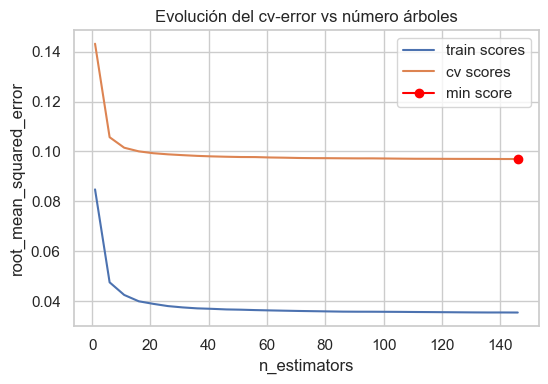

In [70]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:
    
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = False,
                n_jobs       = -1,
                random_state = 123
             )
    
    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

Evaluacón el mejor número de carácterísticas a tener en cuenta

c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\alejo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\alejo\A

Valor óptimo de max_features: 2


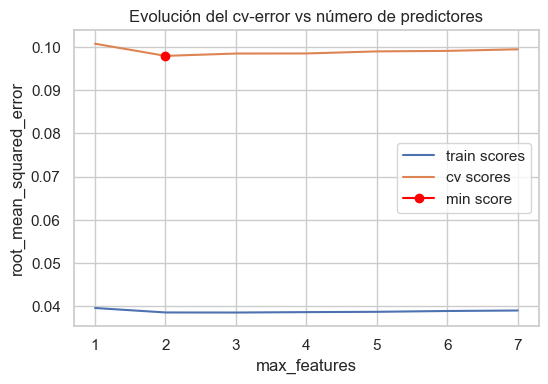

In [71]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de k-cross-validation.
for max_features in max_features_range:
    
    modelo = RandomForestRegressor(
                n_estimators = 20,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    
    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, cv_scores, label="cv scores")
ax.plot(max_features_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_features")
ax.set_title("Evolución del cv-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmin(cv_scores)]}")

##### Hipermarámetros del RandomForest

In [72]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators': [20],
              'max_features': [2, 4, 6],
              'max_depth'   : [ 3, 10, 20]
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestRegressor(random_state = 123),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = - 1,
        cv         = 5, 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
6,20,2,20,-0.098685,0.000922,-0.050256,0.000563
7,20,4,20,-0.098959,0.000593,-0.049134,0.001014
8,20,6,20,-0.099453,0.000889,-0.048720,0.000665
5,10,6,20,-0.106541,0.000987,-0.097740,0.000514


In [73]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'max_depth': 20, 'max_features': 2, 'n_estimators': 20} : -0.09868454707897972 neg_root_mean_squared_error


In [81]:
# Creación del modelo
# ==============================================================================
RFR = RandomForestRegressor(
            n_estimators = 20,
            criterion    = 'squared_error',
            max_depth    = 20,
            max_features = 2,
            oob_score    = False,   #out-of-bag samples
            n_jobs       = -1,
            random_state = 123
         )


# Entrenamiento del modelo
# ==============================================================================
RFR.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features=2, n_estimators=20, n_jobs=-1,
                      random_state=123)

In [82]:
CV=10
scoresr2 = cross_val_score(RFR, X_train, y_train, cv=CV, scoring='r2')
scoresmse = cross_val_score(RFR, X_train, y_train, cv=CV, scoring='neg_mean_absolute_error')
scoresrmse = cross_val_score(RFR, X_train, y_train, cv=CV, scoring='neg_root_mean_squared_error')

df_Metrics_mean.loc[4]=[scoresr2.mean(),-1*scoresmse.mean(),-1*scoresrmse.mean(),'RFR','train']
df_Metrics_std.loc[4]=[scoresr2.std(),scoresmse.std(),scoresrmse.std(),'RFR','train']

#Metrics for test

scoresr2 = cross_val_score(RFR, X_test, y_test, cv=CV, scoring='r2')
scoresmse = cross_val_score(RFR, X_test, y_test, cv=CV, scoring='neg_mean_absolute_error')
scoresrmse = cross_val_score(RFR, X_test, y_test, cv=CV, scoring='neg_root_mean_squared_error')

df_Metrics_mean.loc[5]=[scoresr2.mean(),-1*scoresmse.mean(),-1*scoresrmse.mean(),'RFR','test']
df_Metrics_std.loc[5]=[scoresr2.std(),scoresmse.std(),scoresrmse.std(),'RFR','test']

In [83]:
df_Metrics_mean

,r2,mae,rmse,models,type
0,0.118359,0.104527,0.132382,Regresion,train
1,0.114834,0.105237,0.133444,Regresion,test
2,0.330897,0.089780,0.115326,DT,train
3,0.291512,0.092763,0.119340,DT,test
4,0.519371,0.073844,0.097737,RFR,train
5,0.404946,0.083806,0.109336,RFR,test


In [84]:
importancia_predictores = pd.DataFrame(
                            {'predictor': DatosFiltrados.drop(columns = "Wind Speed").columns,
                             'importancia': RFR.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
6,Wind Direction,0.263718
3,Relative Humidity,0.175014
0,Temperature,0.131560
2,Ozone,0.122934
1,Dew Point,0.118354
5,Precipitable Water,0.117815
4,Pressure,0.070604


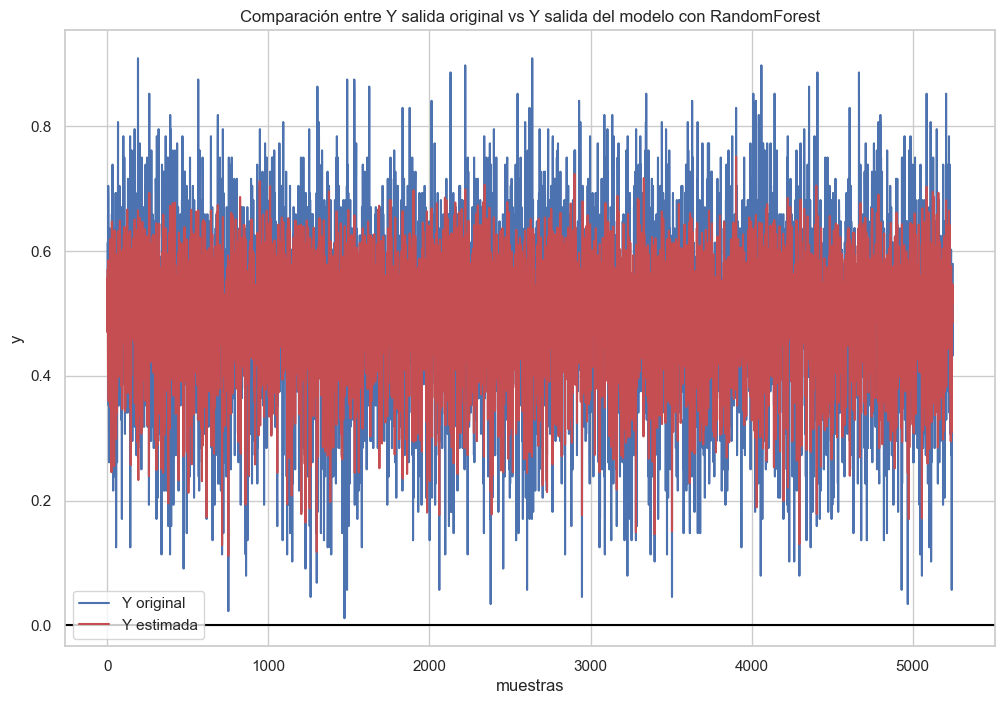

In [92]:
Y_prediRF = RFR.predict(X_test) # Estima los valores de salida del modelo de regresión

fig = plt.figure(figsize=(12,8))
line_1 = plt.plot(np.arange(len(y_test)), y_test, 
                  color = 'b', label='Y original') 
line_2 = plt.plot(np.arange(len(y_test)), Y_prediRF, 
                  color = 'r', label='Y estimada') 
plt.axhline(0, color="black") # Elegir color de la linea horizontal de referencia
plt.legend()
plt.title('Comparación entre Y salida original vs Y salida del modelo con RandomForest') # Titulo de la gráfica
plt.xlabel('muestras') # Etiqueta del eje x
plt.ylabel('y') # Etiqueta del eje y
plt.show() # Mostrar gráfica

### Creación del modelo SVR

##### Hipermarámetros del SVR
Se realiza grid search para el SVR con kernel radial-basis. Lo anterior teniendo en cuenta que se realizó un análisis con los demás kernels y una muesrta pequeña de los datos, obteniendo que el de mejor desempeño fue el rbf.

In [85]:
#Se entena el modelo con múltiples hiperparámetros buscando el mejor

#Se crea una instancia de una SVR Regression
SVMR = SVR()


#Se establecen los hiperparámetros para los kernels rbf y sigmoid
svm_others = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001,'auto', 'scale'],
              'kernel': [ 'rbf']}

#Se unen todos los hiperparametros en una lista de diccionarios  
parameters = [svm_others]


# Se define un GridSearchCV con una validacion cruzada de 10 pliegues y con todos los 
#hierparametros establecidos anteriormente
grid = GridSearchCV(SVMR, param_grid=parameters, cv=10, verbose=3)

#Se entrena el GridSearchCV anterior (2 min. aprox.) con los datos completos
grid_result = grid.fit(X_Completo,y_Completo) 

grid_result

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV 1/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.268 total time=  15.2s
[CV 2/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.250 total time=  14.6s
[CV 3/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.011 total time=  14.2s
[CV 4/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.309 total time=  13.9s
[CV 5/10] END ......C=0.1, gamma=1, kernel=rbf;, score=-0.125 total time=  13.5s
[CV 6/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.191 total time=  13.7s
[CV 7/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.106 total time=  13.6s
[CV 8/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.125 total time=  13.8s
[CV 9/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.236 total time=  13.3s
[CV 10/10] END ......C=0.1, gamma=1, kernel=rbf;, score=0.113 total time=  13.6s
[CV 1/10] END .....C=0.1, gamma=0.1, kernel=rbf;, score=0.083 total time=  16.6s
[CV 2/10] END .....C=0.1, gamma=0.1, kernel=rb

GridSearchCV(cv=10, estimator=SVR(),
             param_grid=[{'C': [0.1, 1, 10, 100, 1000],
                          'gamma': [1, 0.1, 0.01, 0.001, 'auto', 'scale'],
                          'kernel': ['rbf']}],
             verbose=3)

In [86]:
# Se identifican los mejores hiperparámetros
best_params = grid_result.best_params_
print('Best Parameters : ',best_params)

Best Parameters :  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [87]:
# Se crea un modelo SVR con los mejores hiperparámetros 
SVMRegressorR = SVR( kernel = best_params["kernel"]
                    , gamma = best_params["gamma"]
                    , C= best_params["C"])


#Se entrena el modelo con los datos de entrenamiento y prueba iniciales
SVMRegressorR.fit(X_train, y_train)

SVR(C=1)

In [88]:
CV=10
scoresr2 = cross_val_score(SVMRegressorR, X_train, y_train, cv=CV, scoring='r2')
scoresmse = cross_val_score(SVMRegressorR, X_train, y_train, cv=CV, scoring='neg_mean_absolute_error')
scoresrmse = cross_val_score(SVMRegressorR, X_train, y_train, cv=CV, scoring='neg_root_mean_squared_error')

df_Metrics_mean.loc[6]=[scoresr2.mean(),-1*scoresmse.mean(),-1*scoresrmse.mean(),'SVRR','train']
df_Metrics_std.loc[6]=[scoresr2.std(),scoresmse.std(),scoresrmse.std(),'SVRR','train']

#Metrics for test

scoresr2 = cross_val_score(SVMRegressorR, X_test, y_test, cv=CV, scoring='r2')
scoresmse = cross_val_score(SVMRegressorR, X_test, y_test, cv=CV, scoring='neg_mean_absolute_error')
scoresrmse = cross_val_score(SVMRegressorR, X_test, y_test, cv=CV, scoring='neg_root_mean_squared_error')

df_Metrics_mean.loc[7]=[scoresr2.mean(),-1*scoresmse.mean(),-1*scoresrmse.mean(),'SVRR','test']
df_Metrics_std.loc[7]=[scoresr2.std(),scoresmse.std(),scoresrmse.std(),'SVRR','test']

In [89]:
df_Metrics_mean

,r2,mae,rmse,models,type
0,0.118359,0.104527,0.132382,Regresion,train
1,0.114834,0.105237,0.133444,Regresion,test
2,0.330897,0.089780,0.115326,DT,train
3,0.291512,0.092763,0.119340,DT,test
4,0.519371,0.073844,0.097737,RFR,train
5,0.404946,0.083806,0.109336,RFR,test
6,0.420433,0.082690,0.107330,SVRR,train
7,0.373479,0.086531,0.112154,SVRR,test


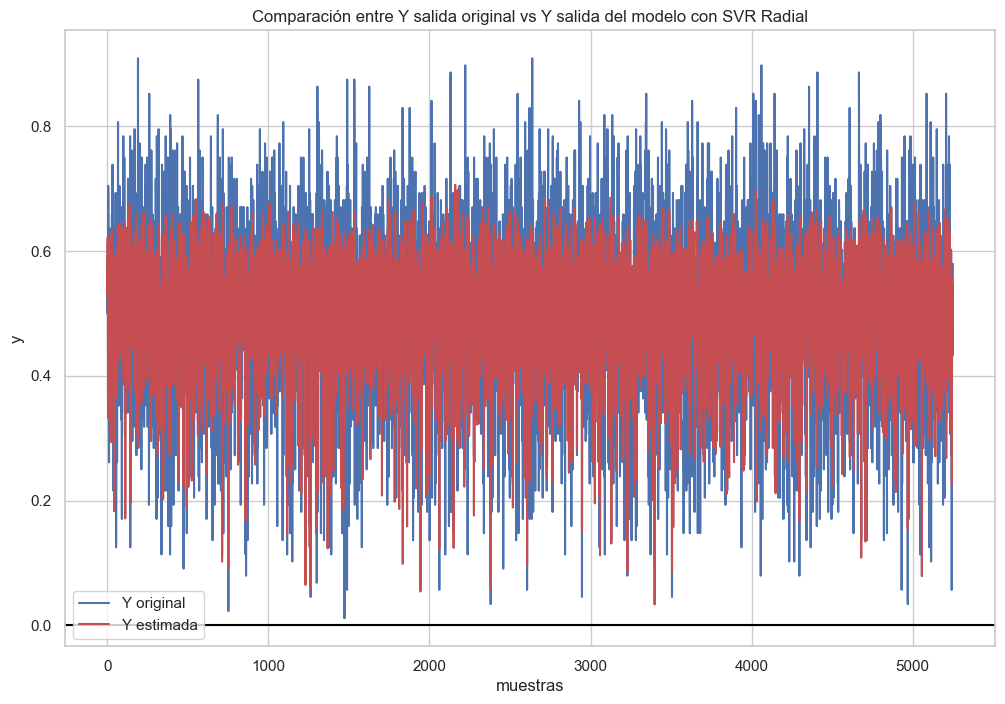

In [91]:
Y_prediSVRR = SVMRegressorR.predict(X_test) # Estima los valores de salida del modelo de regresión

fig = plt.figure(figsize=(12,8))
line_1 = plt.plot(np.arange(len(y_test)), y_test, 
                  color = 'b', label='Y original') 
line_2 = plt.plot(np.arange(len(y_test)), Y_prediSVRR, 
                  color = 'r', label='Y estimada') 
plt.axhline(0, color="black") # Elegir color de la linea horizontal de referencia
plt.legend()
plt.title('Comparación entre Y salida original vs Y salida del modelo con SVR Radial') # Titulo de la gráfica
plt.xlabel('muestras') # Etiqueta del eje x
plt.ylabel('y') # Etiqueta del eje y
plt.show() # Mostrar gráfica

##### SVR con kernel polinomial

Se evaluará el kernel polinomial de grado 2 y 3 para obervar si arroja mejor respuesta que el kernel rafial 

In [ ]:
Se entena el modelo con múltiples hiperparámetros buscando el mejor

#Se crea una instancia de una SVR Regression
SVMRP = SVR()


#Se establecen los hiperparámetros para el Kernel polinomico
svm_poly = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 'auto', 'scale'],
              'degree': [2, 3],
              'kernel': ['poly']}


#Se unen todos los hiperparametros en una lista de diccionarios  
parameters = [svm_poly]


# Se define un GridSearchCV con una validacion cruzada de 10 pliegues y con todos los 
#hierparametros establecidos anteriormente
grid = GridSearchCV(SVMRP, param_grid=parameters, cv=10, verbose=3)

#Se entrena el GridSearchCV anterior (2 min. aprox.) con los datos completos
grid_resultP = grid.fit(X_Completo,y_Completo) 

grid_resultP

In [ ]:
# Se identifican los mejores hiperparámetros
best_paramsP = grid_resultP.best_params_
print('Best Parameters Polinomial : ',best_params)

In [ ]:
# Se crea un modelo SVR con los mejores hiperparámetros 
SVMRegressorP = SVR( kernel = best_paramsP["kernel"]
                    , gamma = best_paramsP["gamma"]
                    , C= best_paramsP["C"]
                    , degree = best_paramsP["degree"])


#Se entrena el modelo con los datos de entrenamiento y prueba iniciales
SVMRegressorP.fit(X_train, y_train)

In [ ]:
CV=10
scoresr2 = cross_val_score(SVMRegressorP, X_train, y_train, cv=CV, scoring='r2')
scoresmse = cross_val_score(SVMRegressorP, X_train, y_train, cv=CV, scoring='neg_mean_absolute_error')
scoresrmse = cross_val_score(SVMRegressorP, X_train, y_train, cv=CV, scoring='neg_root_mean_squared_error')

df_Metrics_mean.loc[8]=[scoresr2.mean(),-1*scoresmse.mean(),-1*scoresrmse.mean(),'SVRP','train']
df_Metrics_std.loc[8]=[scoresr2.std(),scoresmse.std(),scoresrmse.std(),'SVRP','train']

#Metrics for test

scoresr2 = cross_val_score(SVMRegressorP, X_test, y_test, cv=CV, scoring='r2')
scoresmse = cross_val_score(SVMRegressorP, X_test, y_test, cv=CV, scoring='neg_mean_absolute_error')
scoresrmse = cross_val_score(SVMRegressorP, X_test, y_test, cv=CV, scoring='neg_root_mean_squared_error')

df_Metrics_mean.loc[9]=[scoresr2.mean(),-1*scoresmse.mean(),-1*scoresrmse.mean(),'SVRP','test']
df_Metrics_std.loc[9]=[scoresr2.std(),scoresmse.std(),scoresrmse.std(),'SVRP','test']

In [ ]:
Y_prediSVRP = SVMRegressor.predict(X_test) # Estima los valores de salida del modelo de regresión

fig = plt.figure(figsize=(12,8))
line_1 = plt.plot(np.arange(len(y_test)), y_test, 
                  color = 'b', label='Y original') 
line_2 = plt.plot(np.arange(len(y_test)), Y_prediSVRP, 
                  color = 'r', label='Y estimada') 
plt.axhline(0, color="black") # Elegir color de la linea horizontal de referencia
plt.legend()
plt.title('Comparación entre Y salida original vs Y salida del modelo con SVR Polinomial') # Titulo de la gráfica
plt.xlabel('muestras') # Etiqueta del eje x
plt.ylabel('y') # Etiqueta del eje y
plt.show() # Mostrar gráfica